## Imports and data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV again, skipping the second header row
df = pd.read_csv("../data/results_all_cleaned.csv", skiprows=[1])

# Split dataset into groups
df_prolific = df[df["Q0_ProlificID"].notna()]
df_infodienst = df[df["Q0_ProlificID"].isna()]


In [2]:
# Add the second conversation description to the same column
row0 = df.iloc[0]
same_as_header = (row0.values == df.columns.values[:len(row0)]).sum()
if same_as_header >= len(df.columns) * 0.3:
    df = df.iloc[1:].reset_index(drop=True)

meta = df.iloc[:, 0:9]
block_a = df.iloc[:, 9:33]
block_b = df.iloc[:, 33:57]
keep_tail = df.iloc[:, 57:63]

block_b.columns = block_a.columns

df_a = pd.concat([meta.copy(), block_a.copy(), keep_tail.copy()], axis=1)
df_b = pd.concat([meta.copy(), block_b.copy(), keep_tail.copy()], axis=1)
df_with_second_conv = pd.concat([df_a, df_b], axis=0, ignore_index=True)


# Correlations

## Correlation between conversation factors and outcomes

### Prepare numeric subset

In [3]:
cols_interest = ["Q3", "Q6", "Q17", "Q15"]
subset = df_with_second_conv[cols_interest].dropna().copy()

# Q3: number of people -> numeric, round to int, remove outliers >20
subset["Q3_num"] = pd.to_numeric(subset["Q3"], errors="coerce").round()
subset["Q3_num"] = subset["Q3_num"].where(subset["Q3_num"] <= 20)
subset["Q3_num"] = subset["Q3_num"].astype("Int64")

# Q6: whether additional people joined (collapse known/stranger into 1)
map_q6 = {
    "No": 0,
    "Yes, somebody I know": 1,
    "Yes, a stranger": 1
}
subset["Q6_num"] = subset["Q6"].map(map_q6).astype("float")

# Q17: follow-ups (ordinal: No=0, Plan=1, Yes=2)
map_q17 = {
    "No": 0,
    "No, but I plan to have one in the future": 1,
    "Yes, I had (How many?)": 2
}
subset["Q17_num"] = subset["Q17"].map(map_q17).astype("float")

# Q15: behavioral change (binary)
map_q15 = {"No": 0, "Yes": 1}
subset["Q15_num"] = subset["Q15"].map(map_q15).astype("float")

numeric_subset = subset[["Q3_num", "Q6_num", "Q17_num", "Q15_num"]].astype("float")


### Spearman correlation

Spearman correlation matrix (rounded):

                   Conversation size  People joined  Follow-ups  \
Conversation size              1.000          0.548      -0.144   
People joined                  0.548          1.000      -0.117   
Follow-ups                    -0.144         -0.117       1.000   
Behavioral change              0.105          0.106       0.043   

                   Behavioral change  
Conversation size              0.105  
People joined                  0.106  
Follow-ups                     0.043  
Behavioral change              1.000  


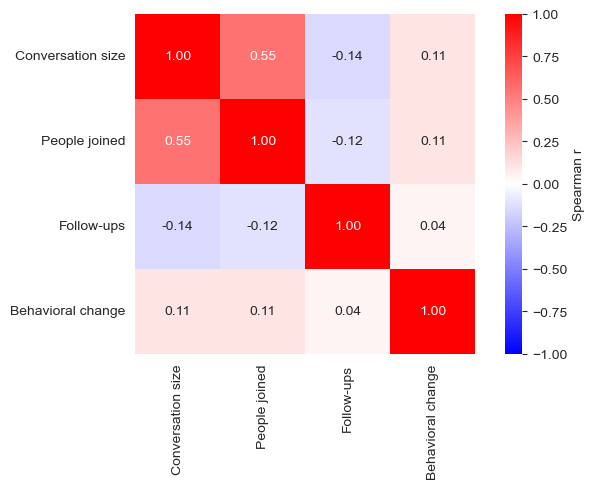

In [4]:
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import spearmanr

corr = numeric_subset.corr(method="spearman")

cols = numeric_subset.columns
pvals = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols)

for i, c1 in enumerate(cols):
    for j, c2 in enumerate(cols):
        if i < j:
            valid = numeric_subset[[c1, c2]].dropna()
            if len(valid) > 1:
                r, p = spearmanr(valid[c1], valid[c2])
            else:
                r, p = np.nan, np.nan
            pvals.loc[c1, c2] = p
            pvals.loc[c2, c1] = p

rename_map = {
    "Q3_num": "Conversation size",
    "Q6_num": "People joined",
    "Q17_num": "Follow-ups",
    "Q15_num": "Behavioral change"
}
corr_renamed = corr.rename(index=rename_map, columns=rename_map)
pvals_renamed = pvals.rename(index=rename_map, columns=rename_map)

print("Spearman correlation matrix (rounded):\n")
print(corr_renamed.round(3))

# Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(
    corr_renamed, annot=True, fmt=".2f",
    cmap="bwr", vmin=-1, vmax=1, square=True,
    cbar_kws={"label": "Spearman r"}
)
plt.tight_layout()
plt.show()


### Logistic regression

In [5]:
reg_data = numeric_subset.dropna(subset=["Q3_num", "Q6_num", "Q17_num", "Q15_num"]).astype(float)

X = reg_data[["Q3_num", "Q6_num", "Q17_num"]]
y = reg_data["Q15_num"]

X = sm.add_constant(X)
logit_model = sm.Logit(y, X).fit(disp=False)
print(logit_model.summary())

q3_range = np.arange(1, 16)
avg_q6 = reg_data["Q6_num"].mean()
avg_q17 = reg_data["Q17_num"].mean()

X_pred = pd.DataFrame({
    "const": 1.0,
    "Q3_num": q3_range,
    "Q6_num": avg_q6,
    "Q17_num": avg_q17
})
pred_probs = logit_model.predict(X_pred)


                           Logit Regression Results                           
Dep. Variable:                Q15_num   No. Observations:                   69
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                            3
Date:                Fri, 29 Aug 2025   Pseudo R-squ.:                 0.03164
Time:                        17:48:47   Log-Likelihood:                -45.970
converged:                       True   LL-Null:                       -47.471
Covariance Type:            nonrobust   LLR p-value:                    0.3911
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9387      0.880     -1.067      0.286      -2.663       0.786
Q3_num         0.2039      0.146      1.399      0.162      -0.082       0.490
Q6_num        -0.0478      0.658     -0.073      0.9

## Correlation between emotions

In [6]:
emotions = [
    "Interested/curious",
    "Worried/anxious",
    "Confident/informed",
    "Annoyed",
    "Helpful/responsible",
    "Indifferent",
    "Other (please describe)"
]

def clean_and_encode(series, emotions):
    cleaned = series.dropna().replace({
        emotions[0]: emotions[0]
    })

    # Remove header-like rows
    cleaned = cleaned[~cleaned.str.contains("How did you feel|How do you think", na=False)]

    # Split values by comma, strip spaces
    split = cleaned.str.split(",").apply(lambda x: [s.strip() for s in x])

    # Create one-hot encoding
    encoded = pd.DataFrame(0, index=series.index, columns=emotions)
    for idx, vals in split.items():
        for v in vals:
            if v in emotions:
                encoded.at[idx, v] = 1
            else:
                encoded.at[idx, "Other (please describe)"] = 1

    return encoded

q11_encoded = clean_and_encode(df_with_second_conv["Q11"].dropna(), emotions)
q13_encoded = clean_and_encode(df_with_second_conv["Q13"].dropna(), emotions)


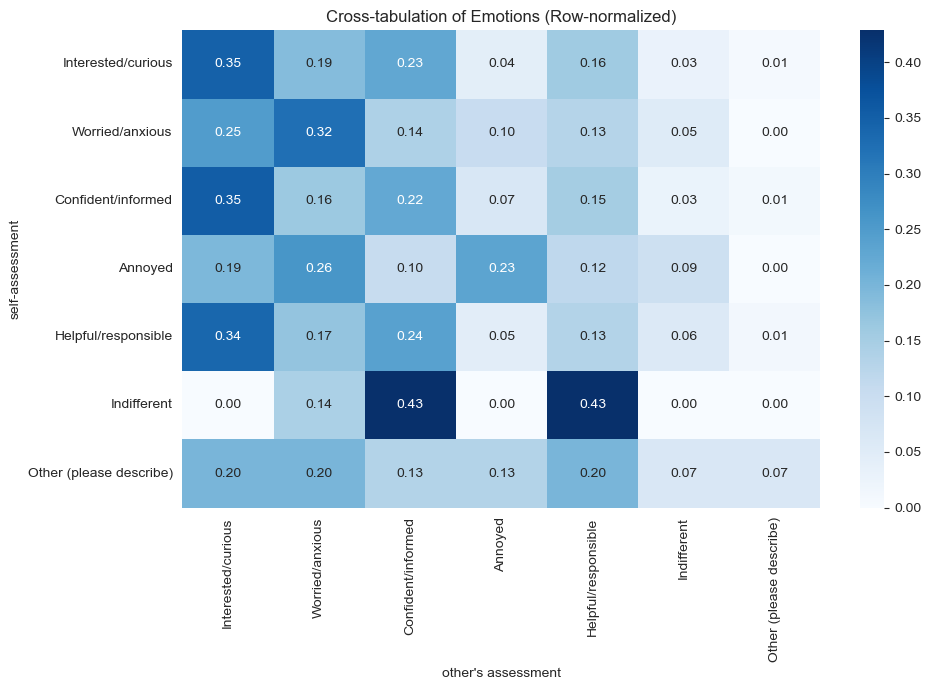

{'Perfect alignment': np.int64(52),
 'Partial alignment': np.int64(100),
 'No alignment': np.int64(76)}

In [7]:
# Cross-tabulation
crosstab = q11_encoded.T.dot(q13_encoded)

crosstab_percent = crosstab.div(crosstab.sum(axis=1), axis=0).fillna(0)

alignment_scores = (q11_encoded & q13_encoded).sum(axis=1)
misalignment_scores = (q11_encoded ^ q13_encoded).sum(axis=1)

alignment_summary = {
    "Perfect alignment": (misalignment_scores == 0).sum(),
    "Partial alignment": ((alignment_scores > 0) & (misalignment_scores > 0)).sum(),
    "No alignment": (alignment_scores == 0).sum()
}

plt.figure(figsize=(10, 7))
sns.heatmap(crosstab_percent, annot=True, cmap="Blues", fmt=".2f")
plt.title("Cross-tabulation of Emotions (Row-normalized)")
plt.ylabel("self-assessment")
plt.xlabel("other's assessment")
plt.tight_layout()
plt.show()

alignment_summary


C:\Users\fernb\miniconda3\envs\cybersec-conv-analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\fernb\miniconda3\envs\cybersec-conv-analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\fernb\miniconda3\envs\cybersec-conv-analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\fernb\miniconda3\envs\cybersec-conv-anal

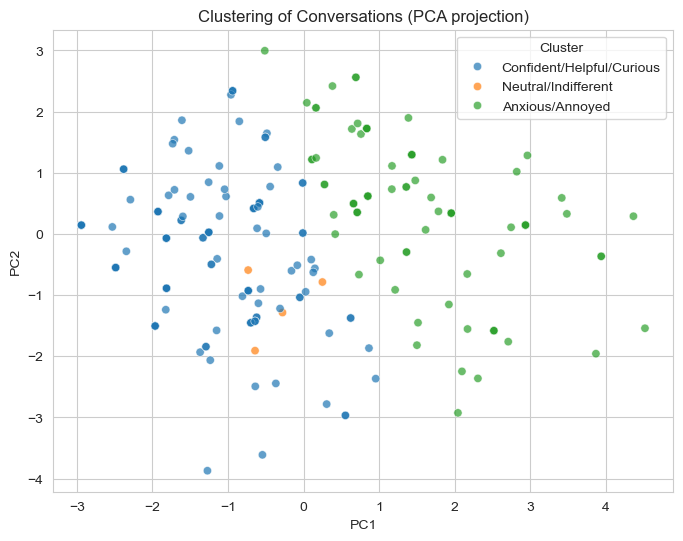

Cluster name mapping (index -> name):
{0: 'Confident/Helpful/Curious', 1: 'Anxious/Annoyed', 2: 'Neutral/Indifferent'}

Cluster sizes and distribution by name:
                           Count  Percentage
Confident/Helpful/Curious    133       58.33
Anxious/Annoyed               91       39.91
Neutral/Indifferent            4        1.75


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

combined = pd.concat([q11_encoded.add_prefix("Q11_"),
                      q13_encoded.add_prefix("Q13_")], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined)

inertias = []
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append((k, km.inertia_))

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=combined.columns)

positive_cols = [
    "Q11_Interested/curious","Q11_Confident/informed","Q11_Helpful/responsible",
    "Q13_Interested/curious","Q13_Confident/informed","Q13_Helpful/responsible"
]
negative_cols = [
    "Q11_Worried/anxious","Q11_Annoyed",
    "Q13_Worried/anxious","Q13_Annoyed"
]
indifferent_cols = ["Q11_Indifferent","Q13_Indifferent"]

profiles = pd.DataFrame({
    "pos_score": centroids[positive_cols].mean(axis=1),
    "neg_score": centroids[negative_cols].mean(axis=1),
    "indiff_score": centroids[indifferent_cols].mean(axis=1),
})

def name_cluster(row, pos_thr=0.15, neg_thr=0.15, indiff_thr=0.15):
    pos_high = row["pos_score"] > pos_thr
    neg_high = row["neg_score"] > neg_thr
    indiff_high = row["indiff_score"] > indiff_thr

    if neg_high and not pos_high:
        return "Anxious/Annoyed"
    if pos_high and not neg_high:
        return "Confident/Helpful/Curious"
    if indiff_high and not pos_high and not neg_high:
        return "Neutral/Indifferent"

    if row["neg_score"] == max(row["pos_score"], row["neg_score"], row["indiff_score"]):
        return "Anxious/Annoyed"
    if row["pos_score"] == max(row["pos_score"], row["neg_score"], row["indiff_score"]):
        return "Confident/Helpful/Curious"
    return "Neutral/Indifferent"

cluster_names = profiles.apply(name_cluster, axis=1)
# Map numeric labels -> human-friendly names
label_to_name = {i: cluster_names.iloc[i] for i in range(len(cluster_names))}
named_labels = pd.Series(labels).map(label_to_name)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=named_labels, alpha=0.7)
plt.title("Clustering of Conversations (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

cluster_profiles = centroids.T
cluster_profiles.columns = [f"{label_to_name[i]} (C{i})" for i in range(len(cluster_names))]

cluster_sizes_named = named_labels.value_counts().sort_values(ascending=False)
cluster_distribution_named = (cluster_sizes_named / cluster_sizes_named.sum() * 100).round(2)

cluster_summary_named = pd.DataFrame({
    "Count": cluster_sizes_named,
    "Percentage": cluster_distribution_named
})

print("Cluster name mapping (index -> name):")
print(label_to_name)
print("\nCluster sizes and distribution by name:")
print(cluster_summary_named)


## Correlation between confidence

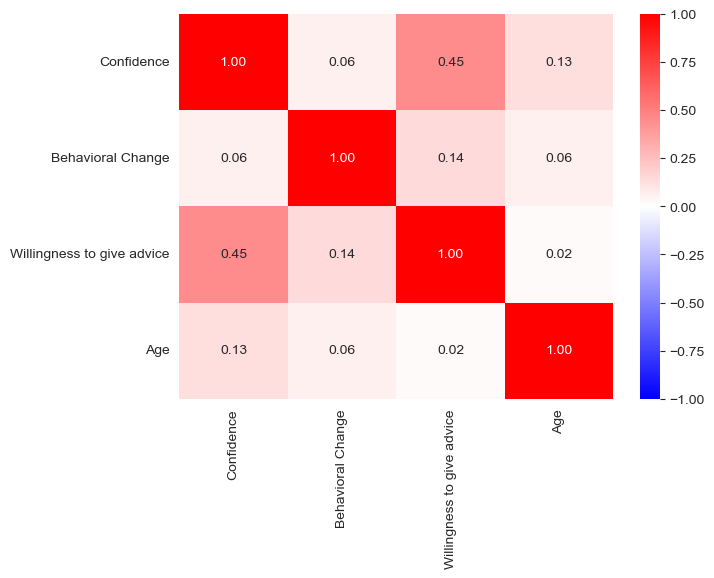

In [9]:
cols = ["Q10_1", "Q15", "Q39_1", "Q35", "Q36", "Q37"]
df_subset = df_with_second_conv[cols].copy()

# Function to extract numeric Likert values
def extract_likert(val):
    if pd.isna(val):
        return np.nan
    try:
        return int(str(val).split()[0])  # take first number in string
    except:
        return np.nan

# Process main variables
df_subset["Q10_1_num"] = df_subset["Q10_1"].apply(extract_likert)
df_subset["Q39_1_num"] = df_subset["Q39_1"].apply(extract_likert)
df_subset["Q15_bin"] = df_subset["Q15"].str.strip().str.lower().map({"yes": 1, "no": 0})

# Process demographics
df_subset["Q35_age"] = pd.to_numeric(df_subset["Q35"], errors="coerce")
df_subset["Q36_gender"] = df_subset["Q36"].astype("category")
df_subset["Q37_country"] = df_subset["Q37"].astype("category")

# Drop missing values for key vars
df_clean = df_subset.dropna(subset=["Q10_1_num", "Q15_bin", "Q39_1_num", "Q35_age", "Q36_gender", "Q37_country"])

# Correlation still only for numeric/ordinal vars
corr = df_clean[["Q10_1_num", "Q15_bin", "Q39_1_num", "Q35_age"]].corr(method="spearman")

# Rename for clarity
corr_renamed = corr.rename(index={
    "Q10_1_num": "Confidence",
    "Q15_bin": "Behavioral Change",
    "Q39_1_num": "Willingness to give advice",
    "Q35_age": "Age"
}, columns={
    "Q10_1_num": "Confidence",
    "Q15_bin": "Behavioral Change",
    "Q39_1_num": "Willingness to give advice",
    "Q35_age": "Age"
})

# Plot heatmap for numeric vars
plt.figure(figsize=(7,5))
sns.heatmap(corr_renamed, annot=True, cmap="bwr", vmin=-1, vmax=1, fmt=".2f")
plt.show()


In [10]:
def extract_likert(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    tok = s.split()[0]
    try:
        return int(tok)
    except Exception:
        for ch in s:
            if ch.isdigit():
                return int(ch)
        return np.nan

def standardize_gender(x: str) -> str:
    x = (x or "").strip().lower()
    if not x or "what is your gender" in x:
        return np.nan
    if x in {"male", "man"}:
        return "Male"
    if x in {"female", "woman"}:
        return "Female"
    if "non" in x and "binary" in x:
        return "Non-binary"
    if "prefer" in x and "not" in x:
        return "Prefer not to say"
    return "Other"

cols = ["Q10_1", "Q15", "Q39_1", "Q35", "Q36", "Q37"]
df_reg = df[cols].copy()

prompt_mask = (
    df_reg["Q36"].astype(str).str.contains("What is your gender?", case=False, na=False)
    | df_reg["Q37"].astype(str).str.contains("What is your country", case=False, na=False)
)
df_reg = df_reg[~prompt_mask]

df_reg["confidence"]  = df_reg["Q10_1"].apply(extract_likert)
df_reg["advice"]      = df_reg["Q39_1"].apply(extract_likert)
df_reg["behavior"]    = df_reg["Q15"].astype(str).str.strip().str.lower().map({"yes":1, "no":0})
df_reg["age"]         = pd.to_numeric(df_reg["Q35"], errors="coerce")
df_reg["gender_std"]  = df_reg["Q36"].astype(str).map(standardize_gender)
df_reg["country_std"] = df_reg["Q37"].astype(str).str.strip()

counts = df_reg["country_std"].value_counts(dropna=True)
keep_countries = counts[counts >= 5].index.tolist()
df_reg["country_reduced"] = np.where(df_reg["country_std"].isin(keep_countries),
                                     df_reg["country_std"], "Other")

X_core = df_reg[["advice", "behavior", "age"]]

X_gender  = pd.get_dummies(df_reg["gender_std"],  prefix="gender",  drop_first=True, dtype=float)
X_country = pd.get_dummies(df_reg["country_reduced"], prefix="country", drop_first=True, dtype=float)

X = pd.concat([X_core, X_gender, X_country], axis=1)

y = df_reg["confidence"]
data = pd.concat([y, X], axis=1).dropna()

y_clean = data["confidence"].astype(int)
X_clean = data.drop(columns=["confidence"]).apply(pd.to_numeric, errors="coerce")

keep_cols = [c for c in X_clean.columns if X_clean[c].nunique() > 1]
X_clean = X_clean[keep_cols]

X_clean = X_clean.astype(float)

print(f"N after dropping NaNs: {len(y_clean)}")
print(f"Predictors used ({len(X_clean.columns)}): {list(X_clean.columns)}")

model = OrderedModel(y_clean, X_clean, distr='logit')
res = model.fit(method='bfgs', disp=False)

print(f"\nCountries kept (>=5 respondents): {sorted(set(df_reg.loc[data.index, 'country_reduced']))}")
print(res.summary())


N after dropping NaNs: 179
Predictors used (15): ['advice', 'behavior', 'age', 'gender_Male', 'gender_Non-binary', 'country_Germany', 'country_Greece', 'country_Italy', 'country_Netherlands', 'country_Other', 'country_Poland', 'country_Portugal', 'country_Spain', 'country_UK', 'country_USA']


NameError: name 'OrderedModel' is not defined

## Sankey

In [ ]:
import re
from itertools import product
import plotly.graph_objects as go
import plotly.colors as pc

Q8_COL  = "Q8"
Q9_COL  = "Q9"
Q15_COL = "Q15"
MULTI_SEP = ","

def split_multi(val, sep=MULTI_SEP):
    if pd.isna(val):
        return []

    parts = [p.strip(' "\'') for p in str(val).split(sep)]
    parts = [re.sub(r'^\s+|\s+$', '', p) for p in parts]
    return [p for p in parts if p and p.lower() != "nan"]

def short_label(s, max_len=28):
    if s is None:
        return ""

    s2 = re.sub(r"\s*\(.*?\)", "", str(s)).strip()
    return (s2[:max_len-1] + "…") if len(s2) > max_len else s2

def order_with_other_last(count_series):
    if count_series is None or len(count_series) == 0:
        return []

    labels = list(count_series.index)
    other_label = "Other (please specify)"
    normal = [x for x in labels if other_label.lower() not in str(x).lower()]
    other  = [x for x in labels if other_label.lower() in  str(x).lower()]
    return normal + other

def rgba(hex_or_rgb, alpha=0.55):
    s = hex_or_rgb.strip()
    if s.startswith("#") and len(s) == 7:
        r = int(s[1:3], 16); g = int(s[3:5], 16); b = int(s[5:7], 16)
        return f"rgba({r},{g},{b},{alpha})"
    if s.startswith("rgb("):
        return s.replace("rgb(", "rgba(").replace(")", f",{alpha})")
    return s

for col in [Q8_COL, Q9_COL, Q15_COL]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in CSV. Found: {list(df.columns)}")

df["_Q8_list"]  = df[Q8_COL].apply(split_multi)
df["_Q9_list"]  = df[Q9_COL].apply(split_multi)
df["_Q15_list"] = df[Q15_COL].apply(split_multi)

resp_Q8  = df["_Q8_list"].explode().dropna().value_counts()   # respondents selecting each Q8
resp_Q9  = df["_Q9_list"].explode().dropna().value_counts()   # respondents selecting each Q9
resp_Q15 = df["_Q15_list"].explode().dropna().value_counts()  # works whether single or multi

# Build edges via cartesian products per respondent
rows_89 = []
for _, r in df.iterrows():
    if r["_Q8_list"] and r["_Q9_list"]:
        for a, b in product(r["_Q8_list"], r["_Q9_list"]):
            rows_89.append((a, b))
edges_89 = (
    pd.DataFrame(rows_89, columns=["Q8", "Q9"]).value_counts().reset_index(name="count")
    if rows_89 else pd.DataFrame(columns=["Q8","Q9","count"])
)

rows_915 = []
for _, r in df.iterrows():
    if r["_Q9_list"] and r["_Q15_list"]:
        for a, b in product(r["_Q9_list"], r["_Q15_list"]):
            rows_915.append((a, b))
edges_915 = (
    pd.DataFrame(rows_915, columns=["Q9", "Q15"]).value_counts().reset_index(name="count")
    if rows_915 else pd.DataFrame(columns=["Q9","Q15","count"])
)

# Order nodes (use respondent totals, then push 'Other' last)
tot_Q8  = resp_Q8.sort_values(ascending=False)
tot_Q9  = resp_Q9.sort_values(ascending=False)
tot_Q15 = resp_Q15.sort_values(ascending=False)

Q8_nodes  = order_with_other_last(tot_Q8)
Q9_nodes  = order_with_other_last(tot_Q9)
Q15_nodes = order_with_other_last(tot_Q15)

# Labels & hover (prefix to avoid loops across columns)
Q8_labels_short  = [f"Q8: {short_label(x)}"  for x in Q8_nodes]
Q9_labels_short  = [f"Q9: {short_label(x)}"  for x in Q9_nodes]
Q15_labels_short = [f"Q15: {short_label(x)}" for x in Q15_nodes]
labels = Q8_labels_short + Q9_labels_short + Q15_labels_short

Q8_hover  = [f"Q8: {x}<br>Total respondents: {int(tot_Q8.get(x,0))}"  for x in Q8_nodes]
Q9_hover  = [f"Q9: {x}<br>Total respondents: {int(tot_Q9.get(x,0))}"  for x in Q9_nodes]
Q15_hover = [f"Q15: {x}<br>Total respondents: {int(tot_Q15.get(x,0))}" for x in Q15_nodes]
node_hover = Q8_hover + Q9_hover + Q15_hover

# Index maps
idx_Q8  = {x: i for i, x in enumerate(Q8_nodes)}
offset_Q9  = len(Q8_nodes)
offset_Q15 = len(Q8_nodes) + len(Q9_nodes)
idx_Q9  = {x: offset_Q9  + i for i, x in enumerate(Q9_nodes)}
idx_Q15 = {x: offset_Q15 + i for i, x in enumerate(Q15_nodes)}

# Build links + hovers + colors
src, tgt, val, link_hover, link_color = [], [], [], [], []

PALETTE_Q8  = pc.qualitative.Pastel1
PALETTE_Q9  = pc.qualitative.Pastel2
PALETTE_Q15 = pc.qualitative.Set1

Q8_colors  = {x: PALETTE_Q8[i % len(PALETTE_Q8)]  for i, x in enumerate(Q8_nodes)}
Q9_colors  = {x: PALETTE_Q9[i % len(PALETTE_Q9)]  for i, x in enumerate(Q9_nodes)}
Q15_colors = {x: PALETTE_Q15[i % len(PALETTE_Q15)] for i, x in enumerate(Q15_nodes)}

if not edges_89.empty:
    for _, r in edges_89.iterrows():
        if r["Q8"] not in idx_Q8 or r["Q9"] not in idx_Q9:
            continue
        s = idx_Q8[r["Q8"]]; t = idx_Q9[r["Q9"]]; c = int(r["count"])
        src.append(s); tgt.append(t); val.append(c)
        denom = tot_Q8.get(r["Q8"], 0)
        pct = (c / denom) * 100 if denom else 0
        link_hover.append(
            f"Q8 → Q9<br>{r['Q8']} → {r['Q9']}<br>"
            f"Count: {c} ({pct:.1f}% of respondents who selected this Q8)"
        )
        link_color.append(rgba(Q8_colors[r["Q8"]], 0.55))

if not edges_915.empty:
    for _, r in edges_915.iterrows():
        if r["Q9"] not in idx_Q9 or r["Q15"] not in idx_Q15:
            continue
        s = idx_Q9[r["Q9"]]; t = idx_Q15[r["Q15"]]; c = int(r["count"])
        src.append(s); tgt.append(t); val.append(c)
        denom = tot_Q9.get(r["Q9"], 0)
        pct = (c / denom) * 100 if denom else 0
        link_hover.append(
            f"Q9 → Q15<br>{r['Q9']} → {r['Q15']}<br>"
            f"Count: {c} ({pct:.1f}% of respondents who selected this Q9)"
        )
        link_color.append(rgba(Q9_colors[r["Q9"]], 0.55))

# Plot
fig_all = go.Figure(data=[go.Sankey(
    arrangement="snap",  # keep columns aligned
    node=dict(
        pad=18,
        thickness=20,
        line=dict(width=0.3, color="rgba(0,0,0,0.25)"),
        label=labels,
        color=[Q8_colors[x] for x in Q8_nodes]
            + [Q9_colors[x] for x in Q9_nodes]
            + [Q15_colors[x] for x in Q15_nodes],
        customdata=node_hover,
        hovertemplate="%{customdata}<extra></extra>",
    ),
    link=dict(
        source=src,
        target=tgt,
        value=val,
        color=link_color,
        customdata=link_hover,
        hovertemplate="%{customdata}<extra></extra>",
    )
)])

fig_all.update_layout(
    title_text="Flow from Trigger (Q8) → Topic (Q9) → Outcome (Q15)",
    font=dict(size=13),
    margin=dict(l=10, r=10, t=50, b=10),
)

fig_all.show()
